In [3]:
import spacy
import re
import pandas as pd
import numpy as np
from collections import Counter

In [5]:
df = pd.read_csv('reviews.csv')
df.head(5) , df.tail(5)

(     rating                                             review
 0  negative  terrible place to work for i just heard a stor...
 1  negative   hours , minutes total time for an extremely s...
 2  negative  my less than stellar review is for service . w...
 3  negative  i m granting one star because there s no way t...
 4  negative  the food here is mediocre at best . i went aft...,
          rating                                             review
 55995  positive  great food . wonderful , friendly service . i ...
 55996  positive  charlotte should be the new standard for moder...
 55997  positive  get the encore sandwich ! ! make sure to get i...
 55998  positive  i m a pretty big ice cream gelato fan . pretty...
 55999  positive  where else can you find all the parts and piec...)

In [6]:
len(df)

56000

In [8]:
# lets bulid vocabulary for this dataset
vocab = {}

In [9]:
def initializeVocabulary():
    unkToken = '<UNK>'
    # token to index
    vocab['t_2_i'] = {}
    # index to token
    vocab['i_2_t'] = {}
    
    vocab['unkToken'] = unkToken
    idx = addToken(unkToken)
    vocab['unkTokenIdx'] = idx

In [10]:
def addToken(token):
    if token in vocab['t_2_i']:
        idx = vocab['t_2_i'][token]
    else:
        # token in not present then we add it
        idx = len(vocab['t_2_i']) 
        vocab['t_2_i'][token] = idx
        vocab['i_2_t'][idx] = token
    return idx

In [11]:
def addManyTokens(tokens):
    idxes = [addToken(token) for token in tokens]
    return idxes

In [12]:
def lookUpToken(token):
    if vocab['unkTokenIdx']>=0:
        return vocab['t_2_i'].get(token,vocab['unkTokenIdx'])
    else:
        return vocab['t_2_i'][token]

In [13]:
def lookUpIndex(idx):
    if idx not in vocab['i_2_t']:
        raise KeyError("the index (%d) is not there" % idx)
    return vocab['i_2_t'][idx]

In [14]:
def vocabularyFromDataFrame(df,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for r in df.review:
        for word in re.split('\W+',r):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [15]:
def vocabularyFromCorpus(Corpus,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for doc in Corpus:
        for word in re.split('\W+',doc):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [16]:
#vocabularyFromDataFrame(df)
Corpus = np.asarray(df['review'])
vocabularyFromCorpus(Corpus)

In [17]:
lookUpToken('the') ,lookUpIndex(lookUpToken('the'))


(38, 'the')

In [18]:
len(vocab['t_2_i'])

8946

In [19]:
def oneHotVector(token,N):
    oneHot = np.zeros((N,1))
    oneHot[lookUpToken(token)] = 1
    return oneHot

In [20]:
N = len(vocab['t_2_i'])
token = 'the'
oneHot = oneHotVector(token,N)

In [27]:
oneHot[30:40] 

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [28]:
oneHot[38]

array([1.])

In [29]:
def computeFeatures(doc,N):
    isFirst = True
    for token in doc:
        oneHot = oneHotVector(token,N)
        if isFirst:
            xF = oneHot
            isFirst = False
        else:
            xF = np.hstack((xF,oneHot))
    return np.mean(xF,axis=1)[:,np.newaxis]

In [30]:
def computeFeatures_fast(doc,N):
    fv = np.zeros(N)
    numTokens = 0
    for token in doc:
        fv[lookUpToken(token)] += 1
        numTokens += 1
    return fv/numTokens

In [31]:
def corpusToFeatureMatrix(Corpus,N):
    isFirst = True
    for doc in Corpus:
        fv = computeFeatures(doc,N)
        if isFirst:
            fM = fv
            isFirst = False
        else:
            fM = np.hstack((fM,fv))
    return fM.T

In [32]:
def corpusToFeatureMatrix_fast(Corpus,N):
    fM = np.zeros((N,len(Corpus)))
    i = 0
    for doc in Corpus:
        fM[:,i] = computeFeatures_fast(doc,N)
        i+=1
    return fM.T

In [33]:
%timeit fv = computeFeatures_fast(Corpus[0],len(vocab['t_2_i']))

324 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%timeit fv = computeFeatures(Corpus[0],len(vocab['t_2_i']))

3.33 s ± 59.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
X = np.asarray(df['review'])
y = np.asarray(df['rating'])

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,shuffle=True)

In [38]:
vocabularyFromCorpus(Xtrain)

In [39]:
N = len(vocab['t_2_i'])
Xtrain_fM = corpusToFeatureMatrix_fast(Xtrain,N)
Xtest_fM = corpusToFeatureMatrix_fast(Xtest,N)

In [40]:
Xtrain_fM.shape

(39200, 7349)

In [41]:
Xtest_fM.shape

(16800, 7349)

In [42]:
#from sklearn.linear_model import LogisticRegression as clf
#from sklearn.naive_bayes import GaussianNB as clf
#from sklearn.ensemble import RandomForestClassifier as clf
from sklearn.svm import SVC as clf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [43]:
M = clf().fit(Xtrain_fM,ytrain)

In [44]:
y_pred = M.predict(Xtest_fM)

Text(89.133125, 0.5, 'Predicted Label')

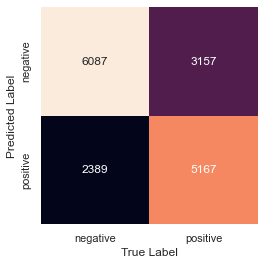

In [45]:
mat = confusion_matrix(ytest,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("True Label")
plt.ylabel("Predicted Label")

In [46]:
Xtrain.shape

(39200,)